# 05 CNN 网络架构

> 深入理解 CNN 的每一层：Conv、ReLU、Pool、Flatten、FC、Dropout、Softmax

---

## 📚 学习目标

在本章结束后，你将能够：

- [ ] 理解 CNN 各层的作用和原理
- [ ] 理解**全连接层 (FC)** 是什么
- [ ] 理解为什么需要 **Flatten**
- [ ] 理解 **ReLU、Dropout、Softmax** 的作用
- [ ] 追踪特征图形状变化
- [ ] 用 PyTorch 构建完整 CNN

## 🔍 前置知识

请确保已完成：

- ✅ **03_convolution_from_scratch.ipynb** - 理解卷积操作
- ✅ **04_pooling_layers.ipynb** - 理解池化层

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 尝试导入 PyTorch
try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    HAS_TORCH = True
    print("PyTorch 已导入")
except ImportError:
    HAS_TORCH = False
    print("PyTorch 未安装，部分代码无法运行")

np.random.seed(42)

---

## 💡 1. CNN 架构概述

### CNN 的标准架构

```
输入图像 (1, 28, 28)
    ↓
┌─────────────────────────────────────┐
│  特征提取部分（学习"看什么"）          │
│                                     │
│  Conv → ReLU → Pool                 │
│  Conv → ReLU → Pool                 │
│  ...                                │
└─────────────────────────────────────┘
    ↓
  Flatten（3D → 1D）
    ↓
┌─────────────────────────────────────┐
│  分类部分（学习"怎么判断"）           │
│                                     │
│  FC → ReLU → Dropout               │
│  FC → Softmax                      │
└─────────────────────────────────────┘
    ↓
  输出（类别概率）
```

### 🏭 工厂流水线比喻

把 CNN 想象成一个工厂流水线：

| 层 | 角色 | 工作内容 |
|---|---|---|
| **卷积层 (Conv)** | 特征检测员 | 发现边缘、颜色、纹理等特征 |
| **ReLU** | 过滤器 | 只保留"有用"的信号（正值） |
| **池化层 (Pool)** | 压缩员 | 把信息压缩，保留重要的，扔掉冗余 |
| **Flatten** | 汇总员 | 把所有检测结果摊开成一张清单 |
| **全连接层 (FC)** | 决策者 | 综合所有信息做最终判断 |
| **Dropout** | 抽查员 | 随机关闭一些神经元，防止"死记硬背" |
| **Softmax** | 概率转换器 | 把分数变成"有多大把握是这个类别" |

---

## 📊 2. CNN 各层详解

### 2.1 卷积层 (Conv) - 特征检测器

前面已经学过，这里简单回顾：

```
作用：用小滤波器扫描图像，检测局部特征

输入：(C_in, H, W)   例如 (1, 28, 28)
输出：(C_out, H', W') 例如 (32, 28, 28)

关键参数：
  - in_channels：输入通道数
  - out_channels：输出通道数（滤波器数量）
  - kernel_size：核大小（如 3x3）
  - padding：填充（same padding 用 1）
  - stride：步幅（默认 1）
```

### 2.2 ReLU 激活函数 - 引入非线性

#### 为什么需要激活函数？

**没有激活函数的问题：**

```
层1: y1 = W1 * x + b1
层2: y2 = W2 * y1 + b2
     y2 = W2 * (W1 * x + b1) + b2
     y2 = (W2 * W1) * x + (W2 * b1 + b2)
     y2 = W' * x + b'   <-- 还是线性变换！

无论多少层，都只能表示线性关系！
但现实世界的问题（图像分类）是非线性的。
```

#### ReLU 是什么？

```
ReLU(x) = max(0, x)

  输入 x < 0  -->  输出 0
  输入 x >= 0 -->  输出 x（不变）
```

**图示：**
```
     y |
       |      /
       |     /
       |    /
-------+---/-------> x
       |  0
       |
```

/Users/lyh/miniconda3/envs/ml_env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 28608 (\N{CJK UNIFIED IDEOGRAPH-6FC0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/lyh/miniconda3/envs/ml_env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27963 (\N{CJK UNIFIED IDEOGRAPH-6D3B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/lyh/miniconda3/envs/ml_env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20989 (\N{CJK UNIFIED IDEOGRAPH-51FD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/lyh/miniconda3/envs/ml_env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


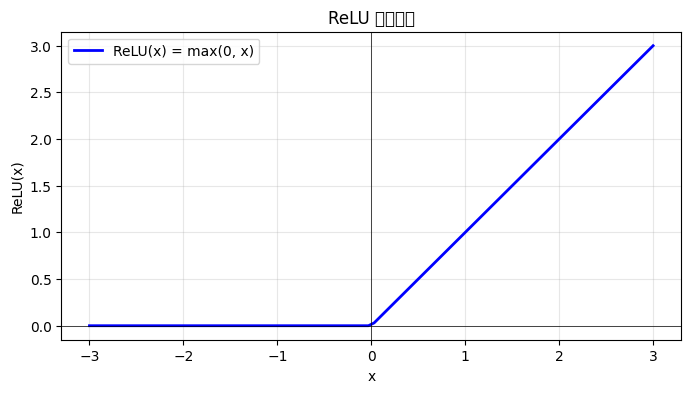

ReLU 的特点：
  1. 计算简单：只需比较和取最大值
  2. 梯度不会消失：正区间梯度恒为 1
  3. 稀疏激活：负值变成 0，网络更高效


In [5]:
# ============================================================
# ReLU 可视化
# ============================================================

def relu(x):
    """ReLU 激活函数: max(0, x)"""
    return np.maximum(0, x)

x = np.linspace(-3, 3, 100)
y = relu(x)

plt.figure(figsize=(8, 4))
plt.plot(x, y, 'b-', linewidth=2, label='ReLU(x) = max(0, x)')
plt.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
plt.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.title('ReLU 激活函数')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("ReLU 的特点：")
print("  1. 计算简单：只需比较和取最大值")
print("  2. 梯度不会消失：正区间梯度恒为 1")
print("  3. 稀疏激活：负值变成 0，网络更高效")

#### 为什么用 ReLU 而不是 Sigmoid？

| 激活函数 | 公式 | 优点 | 缺点 |
|---------|------|------|------|
| Sigmoid | 1/(1+e^(-x)) | 输出在(0,1) | 梯度消失，计算慢 |
| Tanh | (e^x-e^(-x))/(e^x+e^(-x)) | 输出在(-1,1) | 梯度消失 |
| **ReLU** | max(0, x) | 梯度不消失，快 | 负区间"死亡" |

**梯度消失问题：**
- Sigmoid 的梯度最大只有 0.25
- 10 层网络：0.25^10 = 0.0000001
- 梯度几乎为 0，无法学习！

**ReLU 的解决：**
- 正区间梯度恒为 1
- 梯度可以顺利传播到深层

### 2.3 池化层 (Pool) - 下采样压缩

前面已经学过，简单回顾：

```
最大池化 (MaxPool)：取窗口内最大值
平均池化 (AvgPool)：取窗口内平均值

例如 2x2 MaxPool：
  [1, 3]      
  [2, 4]  -->  [4]  （取最大值）

作用：
  1. 减小尺寸，降低计算量
  2. 增加平移不变性
  3. 扩大感受野
```

### 2.4 Flatten - 3D 转 1D 展平

#### 为什么需要 Flatten？

```
问题：
  卷积层输出是 3D 张量：(C, H, W) 如 (64, 7, 7)
  全连接层输入是 1D 向量：(n,)

解决：
  Flatten 把 3D 张量"摊开"成 1D 向量

例子：
  输入: (64, 7, 7)  = 64 个通道，每个 7x7
  展平: 64 x 7 x 7 = 3136 个数
  输出: (3136,)
```

#### 图示

```
  3D 特征图 (2, 2, 2)          1D 向量 (8,)
  
  通道0:    通道1:              
  +--+--+  +--+--+            +--+--+--+--+--+--+--+--+
  |a |b |  |e |f |    -->     |a |b |c |d |e |f |g |h |
  +--+--+  +--+--+            +--+--+--+--+--+--+--+--+
  |c |d |  |g |h |
  +--+--+  +--+--+
```

In [6]:
# ============================================================
# Flatten 演示
# ============================================================

# 模拟 CNN 的特征图输出 (2个通道, 3x3)
feature_map = np.array([
    [[1, 2, 3],
     [4, 5, 6],
     [7, 8, 9]],
    
    [[10, 11, 12],
     [13, 14, 15],
     [16, 17, 18]]
])

print("Flatten 前（3D 特征图）:")
print(f"形状: {feature_map.shape}")
print(f"\n通道 0:\n{feature_map[0]}")
print(f"\n通道 1:\n{feature_map[1]}")

# Flatten 操作
flattened = feature_map.flatten()

print(f"\nFlatten 后（1D 向量）:")
print(f"形状: {flattened.shape}")
print(f"内容: {flattened}")

print(f"\n元素总数不变: 2 x 3 x 3 = {2*3*3} = {len(flattened)}")

Flatten 前（3D 特征图）:
形状: (2, 3, 3)

通道 0:
[[1 2 3]
 [4 5 6]
 [7 8 9]]

通道 1:
[[10 11 12]
 [13 14 15]
 [16 17 18]]

Flatten 后（1D 向量）:
形状: (18,)
内容: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]

元素总数不变: 2 x 3 x 3 = 18 = 18


In [7]:
# PyTorch 中的 Flatten
if HAS_TORCH:
    # 模拟 batch 的特征图 (batch_size=2, channels=64, height=7, width=7)
    x = torch.randn(2, 64, 7, 7)
    print(f"Flatten 前: {x.shape}")
    
    # 方法1: view() - 最常用
    x_flat1 = x.view(x.size(0), -1)  # -1 表示自动计算
    print(f"x.view(batch, -1): {x_flat1.shape}")
    
    # 方法2: flatten() - 更直观
    x_flat2 = x.flatten(start_dim=1)  # 从第1维开始展平，保留batch维
    print(f"x.flatten(start_dim=1): {x_flat2.shape}")
    
    # 方法3: nn.Flatten() - 作为层使用
    flatten_layer = nn.Flatten()
    x_flat3 = flatten_layer(x)
    print(f"nn.Flatten(): {x_flat3.shape}")
    
    print(f"\n64 x 7 x 7 = {64*7*7}")

Flatten 前: torch.Size([2, 64, 7, 7])
x.view(batch, -1): torch.Size([2, 3136])
x.flatten(start_dim=1): torch.Size([2, 3136])
nn.Flatten(): torch.Size([2, 3136])

64 x 7 x 7 = 3136


### 2.5 全连接层 (FC/Linear) - 综合决策

#### 什么是全连接层？

```
FC = Fully Connected = 全连接
也叫：
  - Dense 层（Keras/TensorFlow）
  - Linear 层（PyTorch）

核心特点：每个输入连接到每个输出
```

#### 数学公式

$$y = Wx + b$$

```
其中：
  x: 输入向量, shape (n,)
  W: 权重矩阵, shape (m, n)
  b: 偏置向量, shape (m,)
  y: 输出向量, shape (m,)

例子：
  输入 x = [x1, x2, x3]     (3个输入)
  输出 y = [y1, y2]         (2个输出)
  
  y1 = w11*x1 + w12*x2 + w13*x3 + b1
  y2 = w21*x1 + w22*x2 + w23*x3 + b2
```

#### 图示

```
  输入 (3)              输出 (2)
  
    x1 o-----------------o y1
        \   \      /  /
    x2 o-----\----/-----o y2
        \     \/\/
    x3 o-----------------
    
  每个输入都连接到每个输出
  --> 这就是"全连接"的含义！
```

In [8]:
# ============================================================
# 全连接层演示
# ============================================================

def fully_connected(x, W, b):
    """
    全连接层的前向传播
    
    公式: y = Wx + b
    
    参数:
        x: 输入向量, shape (n,)
        W: 权重矩阵, shape (m, n)
        b: 偏置向量, shape (m,)
    
    返回:
        y: 输出向量, shape (m,)
    """
    return np.dot(W, x) + b

# 示例：3 个输入 -> 2 个输出
x = np.array([1.0, 2.0, 3.0])  # 输入
W = np.array([[0.1, 0.2, 0.3],
              [0.4, 0.5, 0.6]])  # 权重
b = np.array([0.1, 0.2])  # 偏置

y = fully_connected(x, W, b)

print("全连接层示例：")
print(f"输入 x: {x}  shape={x.shape}")
print(f"权重 W:\n{W}  shape={W.shape}")
print(f"偏置 b: {b}  shape={b.shape}")
print(f"\n输出 y = Wx + b: {y}  shape={y.shape}")

# 手动验证
y0 = 0.1*1 + 0.2*2 + 0.3*3 + 0.1
y1 = 0.4*1 + 0.5*2 + 0.6*3 + 0.2
print(f"\n手动验证：")
print(f"y0 = 0.1*1 + 0.2*2 + 0.3*3 + 0.1 = {y0}")
print(f"y1 = 0.4*1 + 0.5*2 + 0.6*3 + 0.2 = {y1}")

全连接层示例：
输入 x: [1. 2. 3.]  shape=(3,)
权重 W:
[[0.1 0.2 0.3]
 [0.4 0.5 0.6]]  shape=(2, 3)
偏置 b: [0.1 0.2]  shape=(2,)

输出 y = Wx + b: [1.5 3.4]  shape=(2,)

手动验证：
y0 = 0.1*1 + 0.2*2 + 0.3*3 + 0.1 = 1.5
y1 = 0.4*1 + 0.5*2 + 0.6*3 + 0.2 = 3.4


#### 全连接 vs 卷积：核心区别

| 特性 | 卷积层 (Conv) | 全连接层 (FC) |
|------|--------------|---------------|
| 连接方式 | **局部连接**（只看 3x3 窗口） | **全部连接**（每个输入都参与） |
| 参数共享 | **是**（同一个核扫遍全图） | **否**（每个连接独立权重） |
| 保留空间结构 | **是**（输出还是 2D） | **否**（输出是 1D） |
| 适合任务 | 特征提取 | 分类决策 |
| 参数量 | 较少 | 较多 |

**为什么 CNN 最后用 FC？**
- 卷积层提取的是"局部特征"
- FC 层综合"所有特征"做最终决策
- 例："有耳朵 + 有胡须 + 有尾巴 --> 这是猫"

In [9]:
# ============================================================
# PyTorch 中的 nn.Linear
# ============================================================

if HAS_TORCH:
    # nn.Linear(in_features, out_features)
    # 等价于: y = x @ W.T + b
    
    fc = nn.Linear(in_features=3136, out_features=128)
    
    print("nn.Linear(3136, 128) 详解：")
    print(f"  in_features = 3136  (输入维度，来自 Flatten)")
    print(f"  out_features = 128  (输出维度，自己设定)")
    print(f"\n参数量计算：")
    print(f"  权重 W: {fc.weight.shape} = {fc.weight.numel():,} 个")
    print(f"  偏置 b: {fc.bias.shape} = {fc.bias.numel():,} 个")
    print(f"  总计: {fc.weight.numel() + fc.bias.numel():,} 个")
    
    # 测试
    x = torch.randn(4, 3136)  # batch_size=4
    y = fc(x)
    print(f"\n测试：")
    print(f"  输入: {x.shape}")
    print(f"  输出: {y.shape}")

nn.Linear(3136, 128) 详解：
  in_features = 3136  (输入维度，来自 Flatten)
  out_features = 128  (输出维度，自己设定)

参数量计算：
  权重 W: torch.Size([128, 3136]) = 401,408 个
  偏置 b: torch.Size([128]) = 128 个
  总计: 401,536 个

测试：
  输入: torch.Size([4, 3136])
  输出: torch.Size([4, 128])


### 2.6 Dropout - 防止过拟合

#### 什么是 Dropout？

```
训练时：随机"关闭"一部分神经元
  - 每次前向传播，随机选择 p% 的神经元
  - 将它们的输出设为 0

测试时：不 Dropout
  - 所有神经元都工作
  - 但输出要乘以 (1-p) 来保持期望一致
```

#### 图示 (Dropout=0.5)

```
训练时（随机关闭 50%）：      测试时（全部开启）：

  o x o x o                   o o o o o
    \ x | x /                   | | | | |
  x o x o x                   o o o o o
  
  o = 激活   x = 关闭         全部激活但权重缩放
```

#### 为什么有效？

1. **防止"死记硬背"**：神经元不能依赖特定的其他神经元
2. **集成学习效果**：相当于同时训练多个不同的子网络
3. **强迫冗余表示**：多个神经元学习相似的特征

In [10]:
# ============================================================
# Dropout 演示
# ============================================================

def dropout_numpy(x, p=0.5, training=True):
    """
    Dropout 的 NumPy 实现
    
    参数:
        x: 输入
        p: 关闭概率（drop probability）
        training: 是否在训练模式
    
    返回:
        dropout 后的输出
    """
    if not training:
        return x  # 测试时不 dropout
    
    # 生成 mask：以 (1-p) 的概率保留
    mask = np.random.binomial(1, 1-p, size=x.shape)
    
    # 应用 mask 并缩放（inverted dropout）
    # 缩放是为了让训练和测试时的期望值一致
    return x * mask / (1 - p)

# 演示
np.random.seed(42)
x = np.ones(10)  # 全 1 的输入

print("Dropout 演示 (p=0.5):")
print(f"输入:        {x}")

for i in range(3):
    y = dropout_numpy(x, p=0.5, training=True)
    print(f"训练 #{i+1}:   {y}")

y_test = dropout_numpy(x, p=0.5, training=False)
print(f"测试时:      {y_test}")

print("\n注意：")
print("  - 训练时每次不同的神经元被关闭")
print("  - 保留的值被放大 2 倍（因为 p=0.5）")
print("  - 测试时输出不变")

Dropout 演示 (p=0.5):
输入:        [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
训练 #1:   [0. 2. 2. 2. 0. 0. 0. 2. 2. 2.]
训练 #2:   [0. 2. 2. 0. 0. 0. 0. 2. 0. 0.]
训练 #3:   [2. 0. 0. 0. 0. 2. 0. 2. 2. 0.]
测试时:      [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

注意：
  - 训练时每次不同的神经元被关闭
  - 保留的值被放大 2 倍（因为 p=0.5）
  - 测试时输出不变


In [11]:
# PyTorch 中的 Dropout
if HAS_TORCH:
    dropout = nn.Dropout(p=0.5)  # 50% 概率关闭
    
    x = torch.ones(1, 10)
    
    print("PyTorch Dropout:")
    print(f"输入: {x}")
    
    # 训练模式
    dropout.train()
    print(f"\n训练模式:")
    for i in range(3):
        y = dropout(x)
        print(f"  输出 #{i+1}: {y}")
    
    # 评估模式
    dropout.eval()
    y = dropout(x)
    print(f"\n评估模式:")
    print(f"  输出: {y}")
    
    print("\n提示: model.train() 和 model.eval() 会切换 Dropout 行为")

PyTorch Dropout:
输入: tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

训练模式:
  输出 #1: tensor([[0., 2., 0., 0., 2., 2., 2., 0., 2., 0.]])
  输出 #2: tensor([[0., 2., 2., 2., 2., 0., 0., 2., 2., 2.]])
  输出 #3: tensor([[2., 2., 0., 0., 0., 0., 2., 2., 2., 2.]])

评估模式:
  输出: tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

提示: model.train() 和 model.eval() 会切换 Dropout 行为


### 2.7 Softmax - 输出概率

#### 什么是 Softmax？

```
将任意实数向量转换为概率分布：
  - 所有输出值在 (0, 1) 之间
  - 所有输出值加起来 = 1
```

#### 公式

$$\text{Softmax}(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{n} e^{x_j}}$$

**步骤拆解：**
1. 对每个元素求指数 $e^{x_i}$（保证为正）
2. 除以所有指数的和（归一化）

#### 例子

```
输入 (logits):  [2.0, 1.0, 0.1]
  | 指数运算
  v
              [e^2.0, e^1.0, e^0.1] = [7.39, 2.72, 1.11]
  | 归一化 (除以总和 11.22)
  v
              [7.39/11.22, 2.72/11.22, 1.11/11.22]
            = [0.66, 0.24, 0.10]
              
输出 (概率):   66% 是类别0, 24% 是类别1, 10% 是类别2
```

In [ ]:
# ============================================================
# Softmax 演示
# ============================================================

def softmax(x):
    """
    Softmax 函数
    
    公式: softmax(x_i) = exp(x_i) / sum(exp(x_j))
    
    注意: 为了数值稳定性，先减去最大值
    """
    x_shifted = x - np.max(x)  # 数值稳定性
    exp_x = np.exp(x_shifted)
    return exp_x / np.sum(exp_x)

# 示例：3分类问题
logits = np.array([2.0, 1.0, 0.1])
probs = softmax(logits)

print("Softmax 详细计算：")
print(f"\n输入 (logits): {logits}")
print(f"\n步骤 1: 指数运算")
print(f"  e^{logits[0]} = {np.exp(logits[0]):.4f}")
print(f"  e^{logits[1]} = {np.exp(logits[1]):.4f}")
print(f"  e^{logits[2]} = {np.exp(logits[2]):.4f}")
print(f"  总和 = {np.sum(np.exp(logits)):.4f}")

print(f"\n步骤 2: 归一化")
for i, p in enumerate(probs):
    print(f"  类别 {i}: {p:.4f} = {p*100:.1f}%")

print(f"\n验证: 概率和 = {np.sum(probs):.4f}")
print(f"预测类别: {np.argmax(probs)}（概率最高的类别）")

#### 重要提示：训练时不需要显式调用 Softmax

```
PyTorch 的 CrossEntropyLoss 已经内置了 Softmax！

正确做法：
  output = model(x)  # 输出 logits（未归一化的分数）
  loss = criterion(output, target)  # CrossEntropyLoss 内部做 Softmax

推理时获取概率：
  probs = F.softmax(output, dim=1)  # 手动调用
  predicted = torch.argmax(probs, dim=1)  # 取最大概率的类别
```

---

## 3. 各层作用对比表

| 层 | 作用 | 输入形状 | 输出形状 | 参数 |
|---|---|---|---|---|
| **Conv2d** | 提取局部特征 | (C, H, W) | (C', H', W') | 有 |
| **ReLU** | 引入非线性 | 任意 | 不变 | 无 |
| **MaxPool2d** | 下采样 | (C, H, W) | (C, H/2, W/2) | 无 |
| **Flatten** | 3D转1D | (C, H, W) | (C*H*W,) | 无 |
| **Linear** | 全连接 | (n,) | (m,) | 有 |
| **Dropout** | 正则化 | 任意 | 不变 | 无 |
| **Softmax** | 概率化 | (n,) | (n,) | 无 |

---

## 4. 形状变化详细追踪

以 MNIST (28x28 灰度图, 10分类) 为例：

In [12]:
# ============================================================
# MNIST CNN 形状变化追踪
# ============================================================

def calc_conv_output(H, k, p=0, s=1):
    """计算卷积输出尺寸"""
    return (H + 2*p - k) // s + 1

print("MNIST CNN 形状变化追踪")
print("=" * 70)

# 记录参数量
total_params = 0

# 初始输入
C, H, W = 1, 28, 28
print(f"{'输入:':<20} ({C}, {H}, {W})")
print()

# Conv1: 1->32, 3x3, padding=1
C_out, k = 32, 3
H = calc_conv_output(H, k, p=1)
params = C * C_out * k * k + C_out  # 权重 + 偏置
total_params += params
C = C_out
print(f"{'Conv(1->32, 3x3, p=1):':<20} ({C}, {H}, {H})  参数: {params:,}")

# ReLU
print(f"{'ReLU:':<20} ({C}, {H}, {H})  参数: 0")

# MaxPool 2x2
H = H // 2
print(f"{'MaxPool(2x2):':<20} ({C}, {H}, {H})  参数: 0")
print()

# Conv2: 32->64, 3x3, padding=1
C_in = C
C_out, k = 64, 3
H = calc_conv_output(H, k, p=1)
params = C_in * C_out * k * k + C_out
total_params += params
C = C_out
print(f"{'Conv(32->64, 3x3, p=1):':<20} ({C}, {H}, {H})  参数: {params:,}")

# ReLU
print(f"{'ReLU:':<20} ({C}, {H}, {H})  参数: 0")

# MaxPool 2x2
H = H // 2
print(f"{'MaxPool(2x2):':<20} ({C}, {H}, {H})  参数: 0")
print()

# Flatten
flat_size = C * H * H
print(f"{'Flatten:':<20} ({flat_size},)  参数: 0")
print(f"  计算: {C} x {H} x {H} = {flat_size}")
print()

# FC1: 3136->128
fc1_in, fc1_out = flat_size, 128
params = fc1_in * fc1_out + fc1_out
total_params += params
print(f"{'Linear(3136->128):':<20} ({fc1_out},)  参数: {params:,}")

# ReLU
print(f"{'ReLU:':<20} ({fc1_out},)  参数: 0")

# Dropout
print(f"{'Dropout(0.5):':<20} ({fc1_out},)  参数: 0")
print()

# FC2: 128->10
fc2_in, fc2_out = fc1_out, 10
params = fc2_in * fc2_out + fc2_out
total_params += params
print(f"{'Linear(128->10):':<20} ({fc2_out},)  参数: {params:,}")

print()
print("=" * 70)
print(f"总参数量: {total_params:,}")

MNIST CNN 形状变化追踪
输入:                  (1, 28, 28)

Conv(1->32, 3x3, p=1): (32, 28, 28)  参数: 320
ReLU:                (32, 28, 28)  参数: 0
MaxPool(2x2):        (32, 14, 14)  参数: 0

Conv(32->64, 3x3, p=1): (64, 14, 14)  参数: 18,496
ReLU:                (64, 14, 14)  参数: 0
MaxPool(2x2):        (64, 7, 7)  参数: 0

Flatten:             (3136,)  参数: 0
  计算: 64 x 7 x 7 = 3136

Linear(3136->128):   (128,)  参数: 401,536
ReLU:                (128,)  参数: 0
Dropout(0.5):        (128,)  参数: 0

Linear(128->10):     (10,)  参数: 1,290

总参数量: 421,642


---

## 5. NumPy 从零实现

In [13]:
# ============================================================
# NumPy 实现完整 CNN（仅前向传播）
# ============================================================

class SimpleCNN_NumPy:
    """
    简单 CNN 的 NumPy 实现（教学用）
    
    架构:
        输入 (1, 28, 28)
          |
        Conv(1->8, 3x3, p=1) -> ReLU -> MaxPool(2x2)
          | (8, 14, 14)
        Conv(8->16, 3x3, p=1) -> ReLU -> MaxPool(2x2)
          | (16, 7, 7)
        Flatten
          | (784,)
        FC(784->64) -> ReLU
          | (64,)
        FC(64->10)
          | (10,) logits
    
    注意：这是简化版本，用于理解原理。
          实际训练请使用 PyTorch/TensorFlow。
    """
    
    def __init__(self):
        # ========================================
        # 初始化权重（随机）
        # 使用 He 初始化: std = sqrt(2/n_in)
        # ========================================
        
        # Conv1: 8个滤波器, 1个输入通道, 3x3核
        self.conv1_w = np.random.randn(8, 1, 3, 3) * np.sqrt(2.0 / (1*3*3))
        self.conv1_b = np.zeros(8)
        
        # Conv2: 16个滤波器, 8个输入通道, 3x3核
        self.conv2_w = np.random.randn(16, 8, 3, 3) * np.sqrt(2.0 / (8*3*3))
        self.conv2_b = np.zeros(16)
        
        # FC1: 784 -> 64
        self.fc1_w = np.random.randn(784, 64) * np.sqrt(2.0 / 784)
        self.fc1_b = np.zeros(64)
        
        # FC2: 64 -> 10
        self.fc2_w = np.random.randn(64, 10) * np.sqrt(2.0 / 64)
        self.fc2_b = np.zeros(10)
    
    def relu(self, x):
        """ReLU 激活函数: max(0, x)"""
        return np.maximum(0, x)
    
    def conv2d(self, x, w, b, padding=1):
        """
        2D 卷积（简化版，单样本）
        
        参数:
            x: 输入, shape (C_in, H, W)
            w: 权重, shape (C_out, C_in, k_h, k_w)
            b: 偏置, shape (C_out,)
            padding: 填充
        
        返回:
            输出, shape (C_out, H', W')
        """
        C_out, C_in, k_h, k_w = w.shape
        _, H, W = x.shape
        
        # 添加 padding
        if padding > 0:
            x = np.pad(x, ((0, 0), (padding, padding), (padding, padding)))
        
        _, H_pad, W_pad = x.shape
        out_h = H_pad - k_h + 1
        out_w = W_pad - k_w + 1
        
        output = np.zeros((C_out, out_h, out_w))
        
        for c_out in range(C_out):
            for i in range(out_h):
                for j in range(out_w):
                    # 提取感受野 (C_in, k_h, k_w)
                    window = x[:, i:i+k_h, j:j+k_w]
                    # 卷积 + 偏置
                    output[c_out, i, j] = np.sum(window * w[c_out]) + b[c_out]
        
        return output
    
    def max_pool(self, x, size=2):
        """
        最大池化
        
        参数:
            x: 输入, shape (C, H, W)
            size: 池化窗口大小
        
        返回:
            输出, shape (C, H//size, W//size)
        """
        C, H, W = x.shape
        out_h, out_w = H // size, W // size
        output = np.zeros((C, out_h, out_w))
        
        for c in range(C):
            for i in range(out_h):
                for j in range(out_w):
                    window = x[c, i*size:(i+1)*size, j*size:(j+1)*size]
                    output[c, i, j] = np.max(window)
        
        return output
    
    def forward(self, x):
        """
        前向传播
        
        参数:
            x: 输入图像, shape (1, 28, 28)
        
        返回:
            logits: 未归一化的类别分数, shape (10,)
        """
        # ========================================
        # 特征提取部分
        # ========================================
        
        # Conv1 -> ReLU -> Pool
        x = self.conv2d(x, self.conv1_w, self.conv1_b)  # (8, 28, 28)
        x = self.relu(x)
        x = self.max_pool(x)  # (8, 14, 14)
        
        # Conv2 -> ReLU -> Pool
        x = self.conv2d(x, self.conv2_w, self.conv2_b)  # (16, 14, 14)
        x = self.relu(x)
        x = self.max_pool(x)  # (16, 7, 7)
        
        # ========================================
        # 分类部分
        # ========================================
        
        # Flatten: 3D -> 1D
        x = x.flatten()  # (784,)
        
        # FC1 -> ReLU
        x = x @ self.fc1_w + self.fc1_b  # (64,)
        x = self.relu(x)
        
        # FC2 (输出层)
        x = x @ self.fc2_w + self.fc2_b  # (10,)
        
        return x


# 测试
cnn_numpy = SimpleCNN_NumPy()
dummy_input = np.random.randn(1, 28, 28)
output = cnn_numpy.forward(dummy_input)

print("NumPy CNN 测试:")
print(f"输入形状: {dummy_input.shape}")
print(f"输出形状: {output.shape}")
print(f"输出值: {output}")
print(f"\n预测类别: {np.argmax(output)}")

NumPy CNN 测试:
输入形状: (1, 28, 28)
输出形状: (10,)
输出值: [ 0.09508174  1.73528619 -2.64636071  0.37759022  1.68438305  4.57012829
 -3.45077384 -1.77040876  3.6401879   0.29042578]

预测类别: 5


---

## 6. PyTorch 实现（带详细注释）

In [14]:
if HAS_TORCH:
    class MNISTNet(nn.Module):
        """
        MNIST 分类 CNN
        
        架构:
            输入: (N, 1, 28, 28)  N=batch_size
              |
            Conv(1->32, 3x3, p=1) -> ReLU -> MaxPool(2x2)
              | (N, 32, 14, 14)
            Conv(32->64, 3x3, p=1) -> ReLU -> MaxPool(2x2)
              | (N, 64, 7, 7)
            Flatten
              | (N, 3136)
            FC(3136->128) -> ReLU -> Dropout(0.5)
              | (N, 128)
            FC(128->10)
              | (N, 10) logits
        """
        
        def __init__(self):
            super().__init__()
            
            # ========================================
            # 特征提取层
            # ========================================
            
            # Conv1: 1个输入通道 -> 32个输出通道
            # kernel_size=3: 使用 3x3 的卷积核
            # padding=1: 填充1圈0，保持尺寸不变 (same padding)
            self.conv1 = nn.Conv2d(
                in_channels=1,    # MNIST 是灰度图，1个通道
                out_channels=32,  # 输出32个特征图
                kernel_size=3,    # 3x3 卷积核
                padding=1         # same padding
            )
            
            # Conv2: 32个输入通道 -> 64个输出通道
            self.conv2 = nn.Conv2d(
                in_channels=32,   # 来自 conv1 的输出
                out_channels=64,  # 输出64个特征图
                kernel_size=3,
                padding=1
            )
            
            # 池化层: 2x2 最大池化，尺寸减半
            self.pool = nn.MaxPool2d(
                kernel_size=2,  # 2x2 窗口
                stride=2        # 步幅2，所以尺寸减半
            )
            
            # ========================================
            # 分类层
            # ========================================
            
            # FC1: 全连接层
            # 输入: 64 x 7 x 7 = 3136 (来自 Flatten)
            # 输出: 128
            self.fc1 = nn.Linear(
                in_features=64 * 7 * 7,  # 3136
                out_features=128
            )
            
            # FC2: 输出层
            # 输入: 128
            # 输出: 10 (对应 0-9 十个数字)
            self.fc2 = nn.Linear(
                in_features=128,
                out_features=10
            )
            
            # Dropout: 训练时随机关闭 50% 的神经元
            self.dropout = nn.Dropout(p=0.5)
        
        def forward(self, x):
            """
            前向传播
            
            参数:
                x: 输入图像, shape (N, 1, 28, 28)
                   N = batch_size
            
            返回:
                logits: 类别分数, shape (N, 10)
                        注意: 返回的是 logits，不是概率！
                        CrossEntropyLoss 会自动处理 Softmax
            """
            # ========================================
            # 特征提取
            # ========================================
            
            # 第一个卷积块: Conv -> ReLU -> Pool
            # (N, 1, 28, 28) -> (N, 32, 28, 28) -> (N, 32, 14, 14)
            x = self.conv1(x)      # 卷积
            x = F.relu(x)          # 激活
            x = self.pool(x)       # 池化
            
            # 第二个卷积块: Conv -> ReLU -> Pool
            # (N, 32, 14, 14) -> (N, 64, 14, 14) -> (N, 64, 7, 7)
            x = self.conv2(x)
            x = F.relu(x)
            x = self.pool(x)
            
            # ========================================
            # 分类
            # ========================================
            
            # Flatten: 3D -> 1D
            # (N, 64, 7, 7) -> (N, 3136)
            x = x.view(x.size(0), -1)  # 保留 batch 维度，展平其余
            
            # FC1 -> ReLU -> Dropout
            # (N, 3136) -> (N, 128)
            x = self.fc1(x)
            x = F.relu(x)
            x = self.dropout(x)  # 只在训练时生效
            
            # FC2 (输出层)
            # (N, 128) -> (N, 10)
            x = self.fc2(x)
            
            return x
    
    # ========================================
    # 测试模型
    # ========================================
    model = MNISTNet()
    
    # 创建假数据: batch_size=4, 1通道, 28x28
    dummy = torch.randn(4, 1, 28, 28)
    
    # 前向传播
    out = model(dummy)
    
    print("PyTorch CNN 测试:")
    print(f"输入形状: {dummy.shape}")
    print(f"输出形状: {out.shape}")
    
    # 打印模型结构
    print("\n模型结构:")
    print(model)
    
    # 计算参数量
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\n参数统计:")
    print(f"  总参数量: {total_params:,}")
    print(f"  可训练参数: {trainable_params:,}")

PyTorch CNN 测试:
输入形状: torch.Size([4, 1, 28, 28])
输出形状: torch.Size([4, 10])

模型结构:
MNISTNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

参数统计:
  总参数量: 421,642
  可训练参数: 421,642


In [ ]:
# ============================================================
# 各层参数量详细统计
# ============================================================

if HAS_TORCH:
    print("各层参数量详细统计:")
    print("=" * 60)
    
    for name, param in model.named_parameters():
        print(f"{name:<30} {str(param.shape):<20} {param.numel():>10,}")
    
    print("=" * 60)
    print(f"{'总计':<50} {total_params:>10,}")

---

## 本章小结

### CNN 架构模式

```
[Conv -> ReLU -> Pool] x N  ->  Flatten  ->  [FC -> ReLU -> Dropout] x M  ->  FC
   特征提取部分                                 分类部分
```

### 各层总结

| 层 | 作用 | 要点 |
|---|---|---|
| **Conv** | 提取局部特征 | 局部连接，参数共享 |
| **ReLU** | 引入非线性 | max(0, x)，防止梯度消失 |
| **Pool** | 下采样 | 减少计算，增加不变性 |
| **Flatten** | 3D转1D | 准备进入全连接层 |
| **FC** | 综合决策 | y = Wx + b，全部连接 |
| **Dropout** | 防止过拟合 | 训练时随机关闭神经元 |
| **Softmax** | 输出概率 | 训练时由 CrossEntropyLoss 处理 |

### 设计原则

1. **空间尺寸**：逐渐减小（通过池化或 stride=2）
2. **通道数**：逐渐增加（32 -> 64 -> 128）
3. **参数量**：FC 层占主要部分

---

## 下一步

继续学习 **06_cnn_backprop.ipynb** - CNN 反向传播

你将学到：
- 卷积层的梯度如何计算
- 池化层的梯度如何传播
- 完整的 CNN 反向传播实现